In [8]:
# conda install -c anaconda cython

## 1. 誤差拡散法の実装

In [3]:
import time
import numpy as np
import matplotlib.pyplot as plt
import cv2

import numba
from image_quantizer import ImageQuantization
# from halftone_c import halftone  # cython

In [4]:
# Visual Model 用パラメータ
A0 = 0.21
A1 = 0.32
A2 = 0.31
A3 = 0.13
B  = 0.04
C  = 1.00

AQ0 = A0
AQ1 = A1
AQ2 = A2
AQ3 = A3
BQ  = B
CQ0 = -AQ0 / B
CQ1 = -AQ1 / B
CQ2 = -AQ2 / B
CQ3 = -AQ3 / B


# 一様量子化器 (Nbit)
def uniform_quantizer_1bit(img):
    img[img >= 128] = 255
    img[img < 128]  = 0
    return img


# 一様量子化器 (Nbit)
def uniform_quantizer_Nbit(img, N):
    level = pow(2, N)
    d = 255 / (level-1)
    return np.round(img / d) * d


# logarithmic quantization (incomplete)
# def logarithmic_quantization(img, N):
#     level = pow(2, N)

#     # Compute the range of the image
#     image_range = np.max(img) - np.min(img)
#     # Calculate the logarithmic base
#     base = np.exp(np.log(image_range) / level)
#     # Calculate the quantization levels
#     quantization_levels = [min_val + (base ** i) for i in range(level)]
    
#     # Quantize the image
#     quantized_image = np.zeros_like(img)
#     for i in range(level - 1):
#         mask = np.logical_and(img >= quantization_levels[i], img <= quantization_levels[i + 1])
#         quantized_image = np.where(mask, quantization_levels[i], quantized_image)
    
#     # Set the maximum value for the last interval
#     mask_last = img >= quantization_levels[level - 1]
#     quantized_image = np.where(mask_last, quantization_levels[level - 1], quantized_image)
    
#     return quantized_image.astype(np.uint8)


# Block-wise quantization
@numba.njit
def block_wise_quantizer(img, N=4):
    # N = {4, 8, 16}
    height, width = img.shape
    result = np.copy(img)

    for i in range(0, height, N):
        for j in range(0, width, N):
            i_end, j_end = i + N, j + N
            if i + N > height: i_end = height
            if j + N > width:  j_end = width
                
            block = img[i:i_end, j:j_end]  # N×Nのブロックを取得
            max_value = np.max(block)
            min_value = np.min(block)
            thresh = (max_value + min_value) / 2

            for x in range(N):
                for y in range(N):
                    if block[x, y] >= thresh:
                        result[i+x, j+y] = thresh
                    else:
                        result[i+x, j+y] = min_value

    return result


# Halftone with ODQ (1bit)
@numba.njit
def halftone_visual_model_1bit(img):
    threshold = 128

    xi = np.zeros((img.shape[1]+2, img.shape[0]+1))
    vd = np.zeros((img.shape[1], img.shape[0]), dtype=np.int64)
    ud = img.T

    for j in range(img.shape[0]):
        for i in range(img.shape[1]):
            tmp = np.array([[CQ0,CQ1,CQ2,CQ3,1]]) @ np.array([[xi[i,j],xi[i,j+1],xi[i+1,j], xi[i+2,j],ud[i,j]]]).T
            if tmp > threshold:
                vd[i,j] = 255
            A1 = np.array([[AQ0,AQ1,AQ2,AQ3,BQ]])
            A2 = np.array([[xi[i,j],xi[i,j+1],xi[i+1,j],xi[i+2,j],(vd[i,j] - ud[i,j])]]).T
            xi[i+1, j+1] = (A1 @ A2)[0,0]

    return vd.T

# Halftone with ODQ (Nbit)
@numba.njit
def halftone_visual_model_Nbit(img, N):
    level = pow(2, N)
    d = 255 / (level-1)

    xi = np.zeros((img.shape[1]+2, img.shape[0]+1))
    vd = np.zeros((img.shape[1], img.shape[0]), dtype=np.int64)
    ud = img.T

    for j in range(img.shape[0]):
        for i in range(img.shape[1]):
            vd[i,j] = np.round(((np.array([[CQ0,CQ1,CQ2,CQ3,1]]) @ np.array([[xi[i,j],xi[i,j+1],xi[i+1,j], xi[i+2,j],ud[i,j]]]).T)[0, 0] / d)) * d
            xi[i+1, j+1] = (np.array([[AQ0,AQ1,AQ2,AQ3,BQ]]) @ np.array([[xi[i,j],xi[i,j+1],xi[i+1,j],xi[i+2,j],(vd[i,j] - ud[i,j])]]).T)[0,0]

    return vd.T

# halftone with error diffusion
@numba.njit
def halftone_error_diffusion_1bit(img, h=None, method="jjn"):

    # Processing
    if method == "jjn":
        ## Jarvis, Judice & Ninke
        h = np.array([[0, 0, 0, 7, 5],
                      [3, 5, 7, 5, 3],
                      [1, 3, 5, 3, 1]]) / 48
        FSTEPJ = 2
        BSTEPJ = -2
        FSTEPI = 2 
    if method == "fs":
        ## floyd-Steinburg
        h = np.array([[0, 0, 7],
                      [3, 5, 1]]) /16
        FSTEPJ = 1
        BSTEPJ = -1
        FSTEPI = 1
    if method == "custom":
        if h.shape[0]*h.shape[1] == 6:
            FSTEPJ = 1
            BSTEPJ = -1
            FSTEPI = 1
        if h.shape[0]*h.shape[1] == 15:
            FSTEPJ = 2
            BSTEPJ = -2
            FSTEPI = 2

    tmp1 = np.concatenate((np.ones((img.shape[0], -BSTEPJ)), img, np.ones((img.shape[0], FSTEPJ))), axis=1)
    tmp2 = np.concatenate((np.ones((FSTEPI, -BSTEPJ)), np.ones((FSTEPI, img.shape[1])), np.ones((FSTEPI, FSTEPJ))), axis=1)
    tmp = np.concatenate((tmp1, tmp2), axis=0)

    newImage = np.zeros((img.shape[0]+FSTEPI, img.shape[1]+FSTEPJ - BSTEPJ), dtype=np.int64)

    for i in range(img.shape[0]):
        for j in range(img.shape[1]+FSTEPJ):
            if (i > img.shape[0] or j > img.shape[1] - BSTEPJ or j <= -BSTEPJ):
                    newImage[i,j] = 255 if tmp[i,j] > 128 else 0
            else:
                err1 = tmp[i,j] - 0
                err2 = tmp[i,j] - 255

                if (err1 * err1 < err2 * err2):
                    newImage[i,j] = 0
                    err3 = err1
                else:
                    newImage[i,j] = 255
                    err3 = err2

                for k in range(1, FSTEPI + 2):
                    for l in range(BSTEPJ, FSTEPJ+1):
                        tmp[i+k-1, j+l] += err3 * h[k-1, -1*BSTEPJ+l]

    return newImage[:-FSTEPI, :(FSTEPJ-BSTEPJ)]

@numba.njit
def error_diffusion_quantization(img, h=None, method="custom", N=1):

    # Processing
    if method == "jjn":
        ## Jarvis, Judice & Ninke
        h = np.array([[0, 0, 0, 7, 5],
                      [3, 5, 7, 5, 3],
                      [1, 3, 5, 3, 1]]) / 48
        FSTEPJ = 2
        BSTEPJ = -2
        FSTEPI = 2 
    if method == "fs":
        ## floyd-Steinburg
        h = np.array([[0, 0, 7],
                      [3, 5, 1]]) /16
        FSTEPJ = 1
        BSTEPJ = -1
        FSTEPI = 1
    if method == "custom":
        if h.shape[0]*h.shape[1] == 6:
            FSTEPJ = 1
            BSTEPJ = -1
            FSTEPI = 1
        if h.shape[0]*h.shape[1] == 15:
            FSTEPJ = 2
            BSTEPJ = -2
            FSTEPI = 2
    
    level = pow(2, N)
    d = 255 / (level-1)

    tmp1 = np.concatenate((np.ones((img.shape[0], -BSTEPJ)), img, np.ones((img.shape[0], FSTEPJ))), axis=1)
    tmp2 = np.concatenate((np.ones((FSTEPI, -BSTEPJ)), np.ones((FSTEPI, img.shape[1])), np.ones((FSTEPI, FSTEPJ))), axis=1)
    tmp = np.concatenate((tmp1, tmp2), axis=0)

    newImage = np.zeros((img.shape[0]+FSTEPI, img.shape[1]+FSTEPJ - BSTEPJ), dtype=np.int64)

    for i in range(img.shape[0]):
        for j in range(img.shape[1]+FSTEPJ):
            if (i > img.shape[0] or j > img.shape[1] - BSTEPJ or j <= -BSTEPJ):
                newImage[i,j] = np.round(newImage[i,j] / d) * d
            else:
                tmp_ceil  = np.ceil(tmp[i,j] / d) * d
                tmp_floor = np.floor(tmp[i,j] / d) * d 

                err1 = tmp[i,j] - tmp_floor
                err2 = tmp[i,j] - tmp_ceil

                if (err1 * err1 < err2 * err2):
                    newImage[i,j] = tmp_floor
                    err3 = err1
                else:
                    newImage[i,j] = tmp_ceil
                    err3 = err2

                for k in range(1, FSTEPI + 2):
                    for l in range(BSTEPJ, FSTEPJ+1):
                        tmp[i+k-1, j+l] += err3 * h[k-1, -1*BSTEPJ+l]

    return newImage[:-FSTEPI, FSTEPJ:BSTEPJ]

## 2. 実行時間の記録

In [70]:
img = cv2.imread("../datasets/raw_imgs/mh01.png")
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
iq = ImageQuantization()
h = np.array([0, 0] + [17, 5, 15, 3]).reshape(2, 3)
h = h / np.mean(h)

print("===== TEST halftone with numba =====")
for i in range(1, 8):
    print(f"{i}bit now...")
#     %timeit _ = iq.uniform_quantization(img_gray, N=i)
    %timeit _ = iq.error_diffusion_quantization(img_gray, N=i, method="fs", h=None)

# for i in [4, 8, 16]:
#     print(f"{i}block now...")
#     %timeit _ = iq.blockwise_quantization(img_gray, N=i)

===== TEST halftone with numba =====
1bit now...
9.47 ms ± 34.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2bit now...
9.59 ms ± 259 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3bit now...
9.89 ms ± 736 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4bit now...
9.52 ms ± 48.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5bit now...
10.4 ms ± 1.38 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
6bit now...
10.3 ms ± 767 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
7bit now...
9.44 ms ± 65.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [41]:
img = cv2.imread("../datasets/raw_imgs/mh01.png")
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
h = np.array([0, 0] + [17, 5, 15, 3]).reshape(2, 3)
h = h / np.mean(h)

print("===== TEST halftone with numba =====")
%timeit _ = uniform_quantizer_1bit(img_gray)
%timeit _ = uniform_quantizer_Nbit(img_gray, 3)
%timeit _ = logarithmic_quantization(img_gray, 3)
%timeit _ = block_wise_quantizer(img_gray)
%timeit _ = halftone_visual_model_1bit(img_gray)
%timeit _ = halftone_visual_model_Nbit(img_gray, 3)
%timeit _ = halftone_error_diffusion_1bit(img_gray, method="jjn")
%timeit _ = error_diffusion_quantization(img_gray, h=h)

# print("===== TEST halftone with cython =====")
# %timeit _ = halftone.uniform_quantizer_1bit_cy(img_gray)
# %timeit _ = halftone.uniform_quantizer_Nbit_cy(img_gray, 3)
# %timeit _ = halftone.halftone_visual_model_1bit_cy(img_gray)
# %timeit _ = halftone.halftone_visual_model_Nbit_cy(img_gray, 3)
# %timeit _ = halftone.halftone_error_diffusion_1bit_cy(img_gray, method="jjn")

===== TEST halftone with numba =====
534 µs ± 8.01 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
699 µs ± 11.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
5.96 ms ± 35.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
930 µs ± 33.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
317 ms ± 14.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
292 ms ± 2.31 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
5.23 ms ± 145 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
7.96 ms ± 128 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
img = cv2.imread("../datasets/raw_imgs/mh01.png")
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

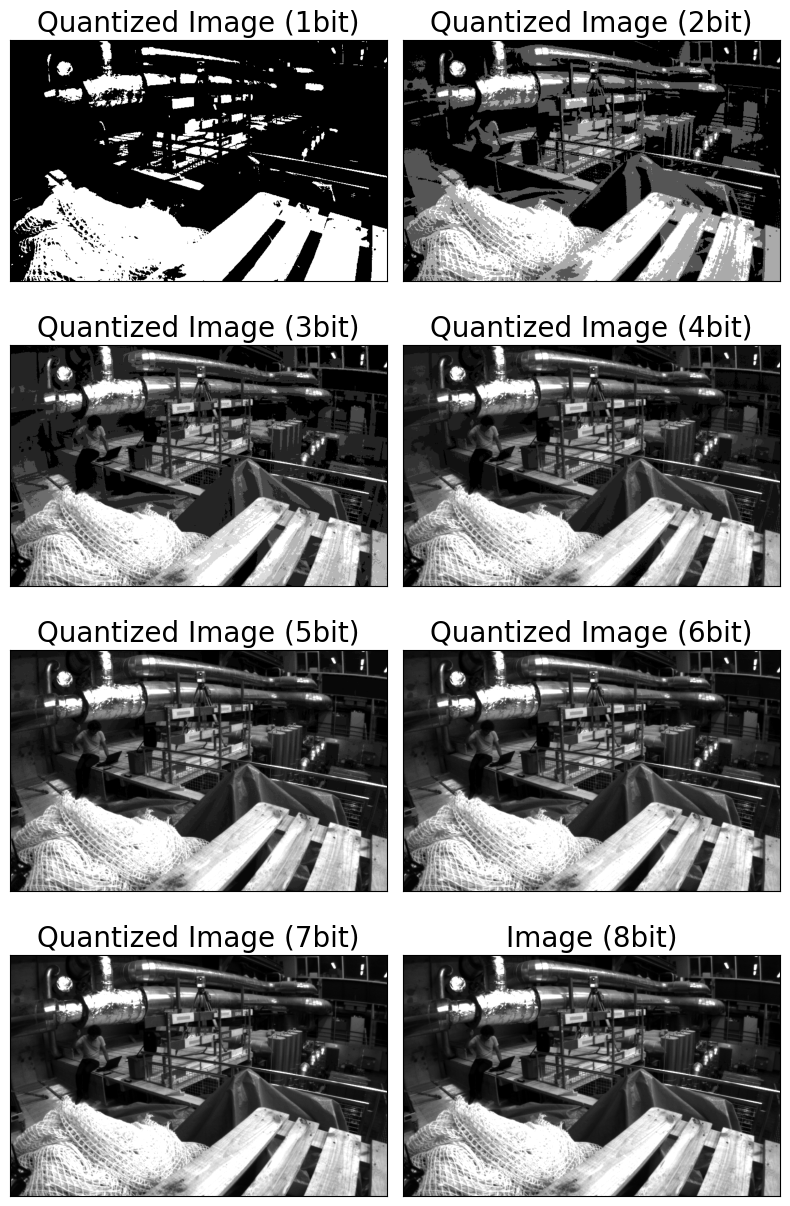

In [9]:
# 一様量子化器

plt.figure(figsize=(8,12.5), dpi=100)

for i in range(1, 8):
    quantized_img = uniform_quantizer_Nbit(img_gray, i)
    
    plt.subplot(420 + i)
    plt.imshow(quantized_img, cmap="gray")
    plt.xticks([])
    plt.yticks([])
    plt.title(f"Quantized Image ({i}bit)", fontsize=20)

plt.subplot(428)
plt.imshow(img_gray, cmap="gray")
plt.title(f"Image (8bit)", fontsize=20)
plt.xticks([])
plt.yticks([])
    
plt.tight_layout()
plt.show()

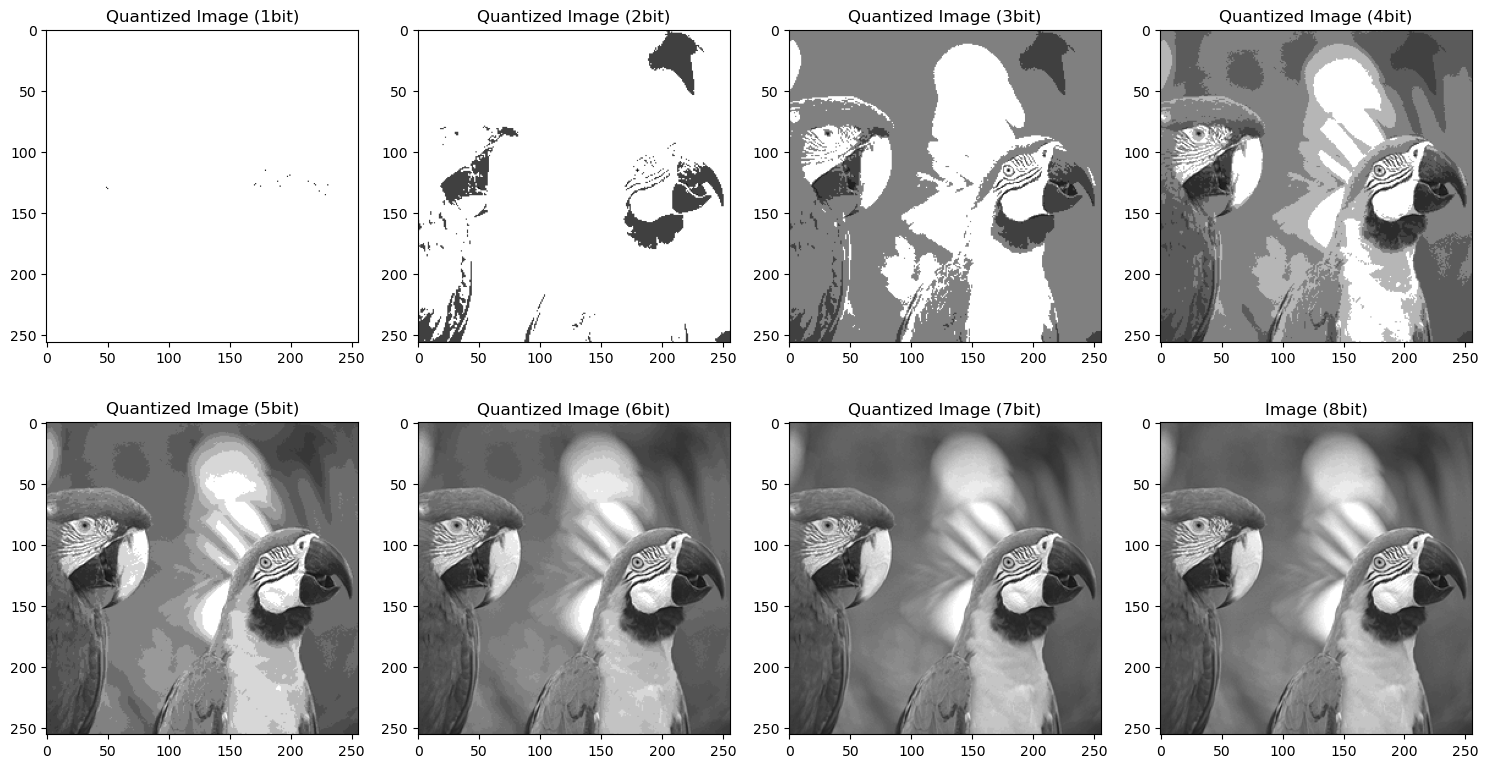

In [27]:
# 非線形対数型量子化器

plt.figure(figsize=(15,8), dpi=100)

for i in range(1, 8):
    quantized_img = logarithmic_quantization(img_gray, i)
    
    plt.subplot(240 + i)
    plt.imshow(quantized_img, cmap="gray")
    plt.title(f"Quantized Image ({i}bit)")

plt.subplot(248)
plt.imshow(quantized_img, cmap="gray")
plt.title(f"Image (8bit)")

plt.tight_layout()
plt.show()

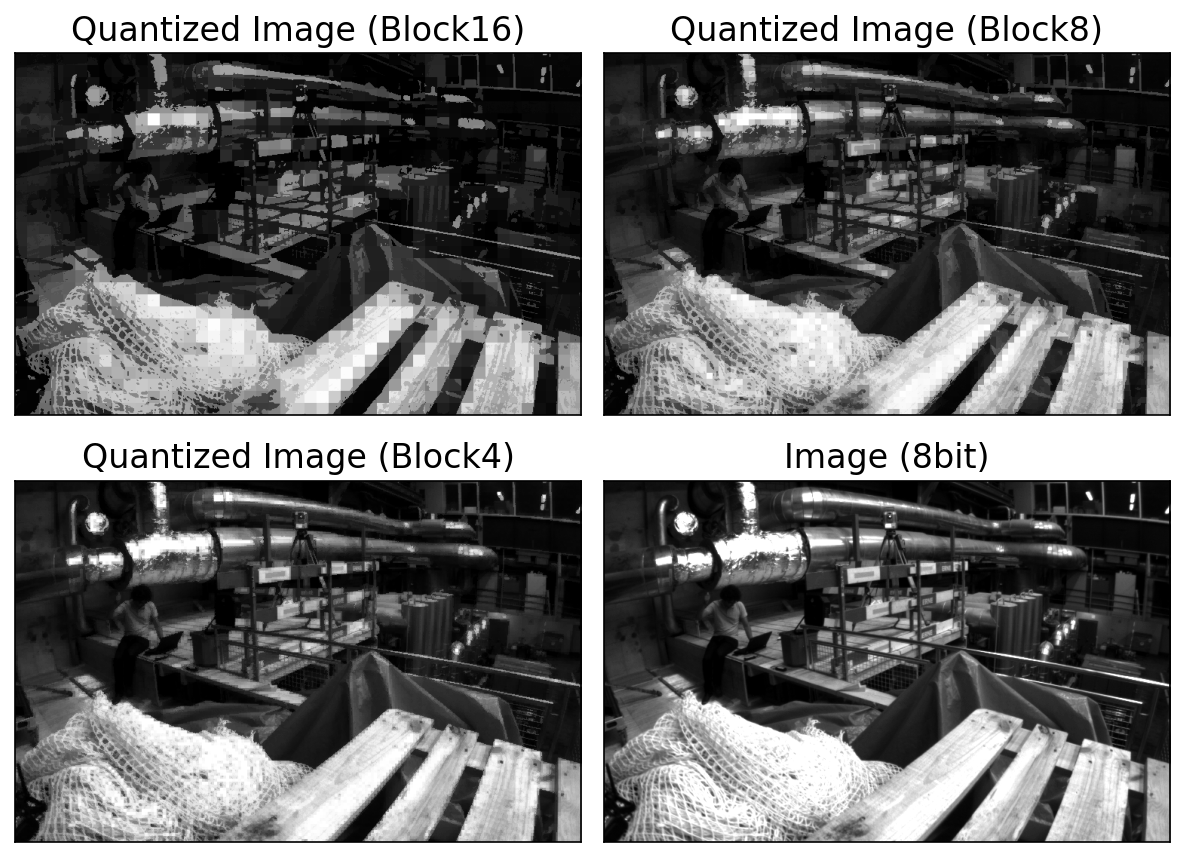

In [14]:
# Block-wise Quantization

plt.figure(figsize=(8, 6), dpi=150)

for i, n in enumerate([16, 8, 4]):
    quantized_img = block_wise_quantizer(img_gray, n)
    
    plt.subplot(221+ i)
    plt.imshow(quantized_img, cmap="gray")
    plt.xticks([])
    plt.yticks([])
    plt.title(f"Quantized Image (Block{n})", fontsize=16)

plt.subplot(224)
plt.imshow(img_gray, cmap="gray")
plt.xticks([])
plt.yticks([])
plt.title(f"Image (8bit)", fontsize=16)

plt.tight_layout()
plt.show()

Image Size: (480, 752)


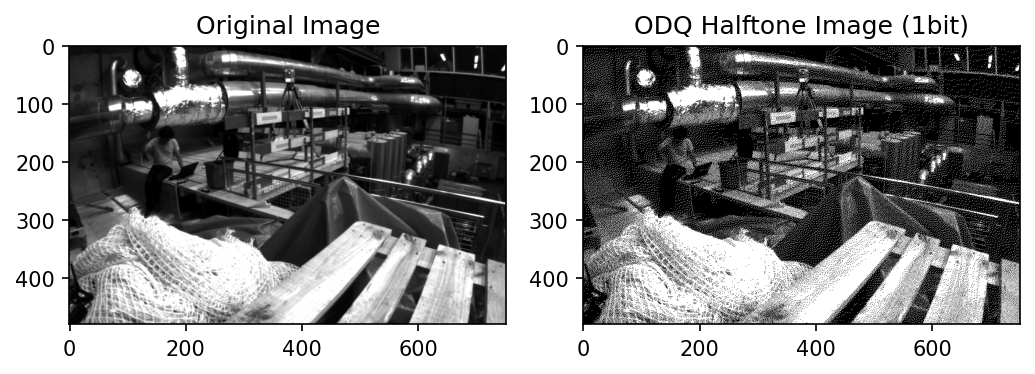

In [51]:
## initial setup (1: ODQ, 2: ErrorDiffusion, 3: DitherMatrix)

## Way.1 Visual Model(Fornasini-Marchesini)
img_halftone = halftone_visual_model_Nbit(img_gray, 1)

print(f"Image Size: {img_gray.shape}")


plt.figure(figsize=(8,8), dpi=100)
plt.subplot(121)
plt.imshow(img_gray, cmap="gray")
plt.title("Original Image")
plt.subplot(122)
plt.imshow(img_halftone, cmap="gray")
plt.title("ODQ Halftone Image (1bit)")

plt.tight_layout()
plt.show()

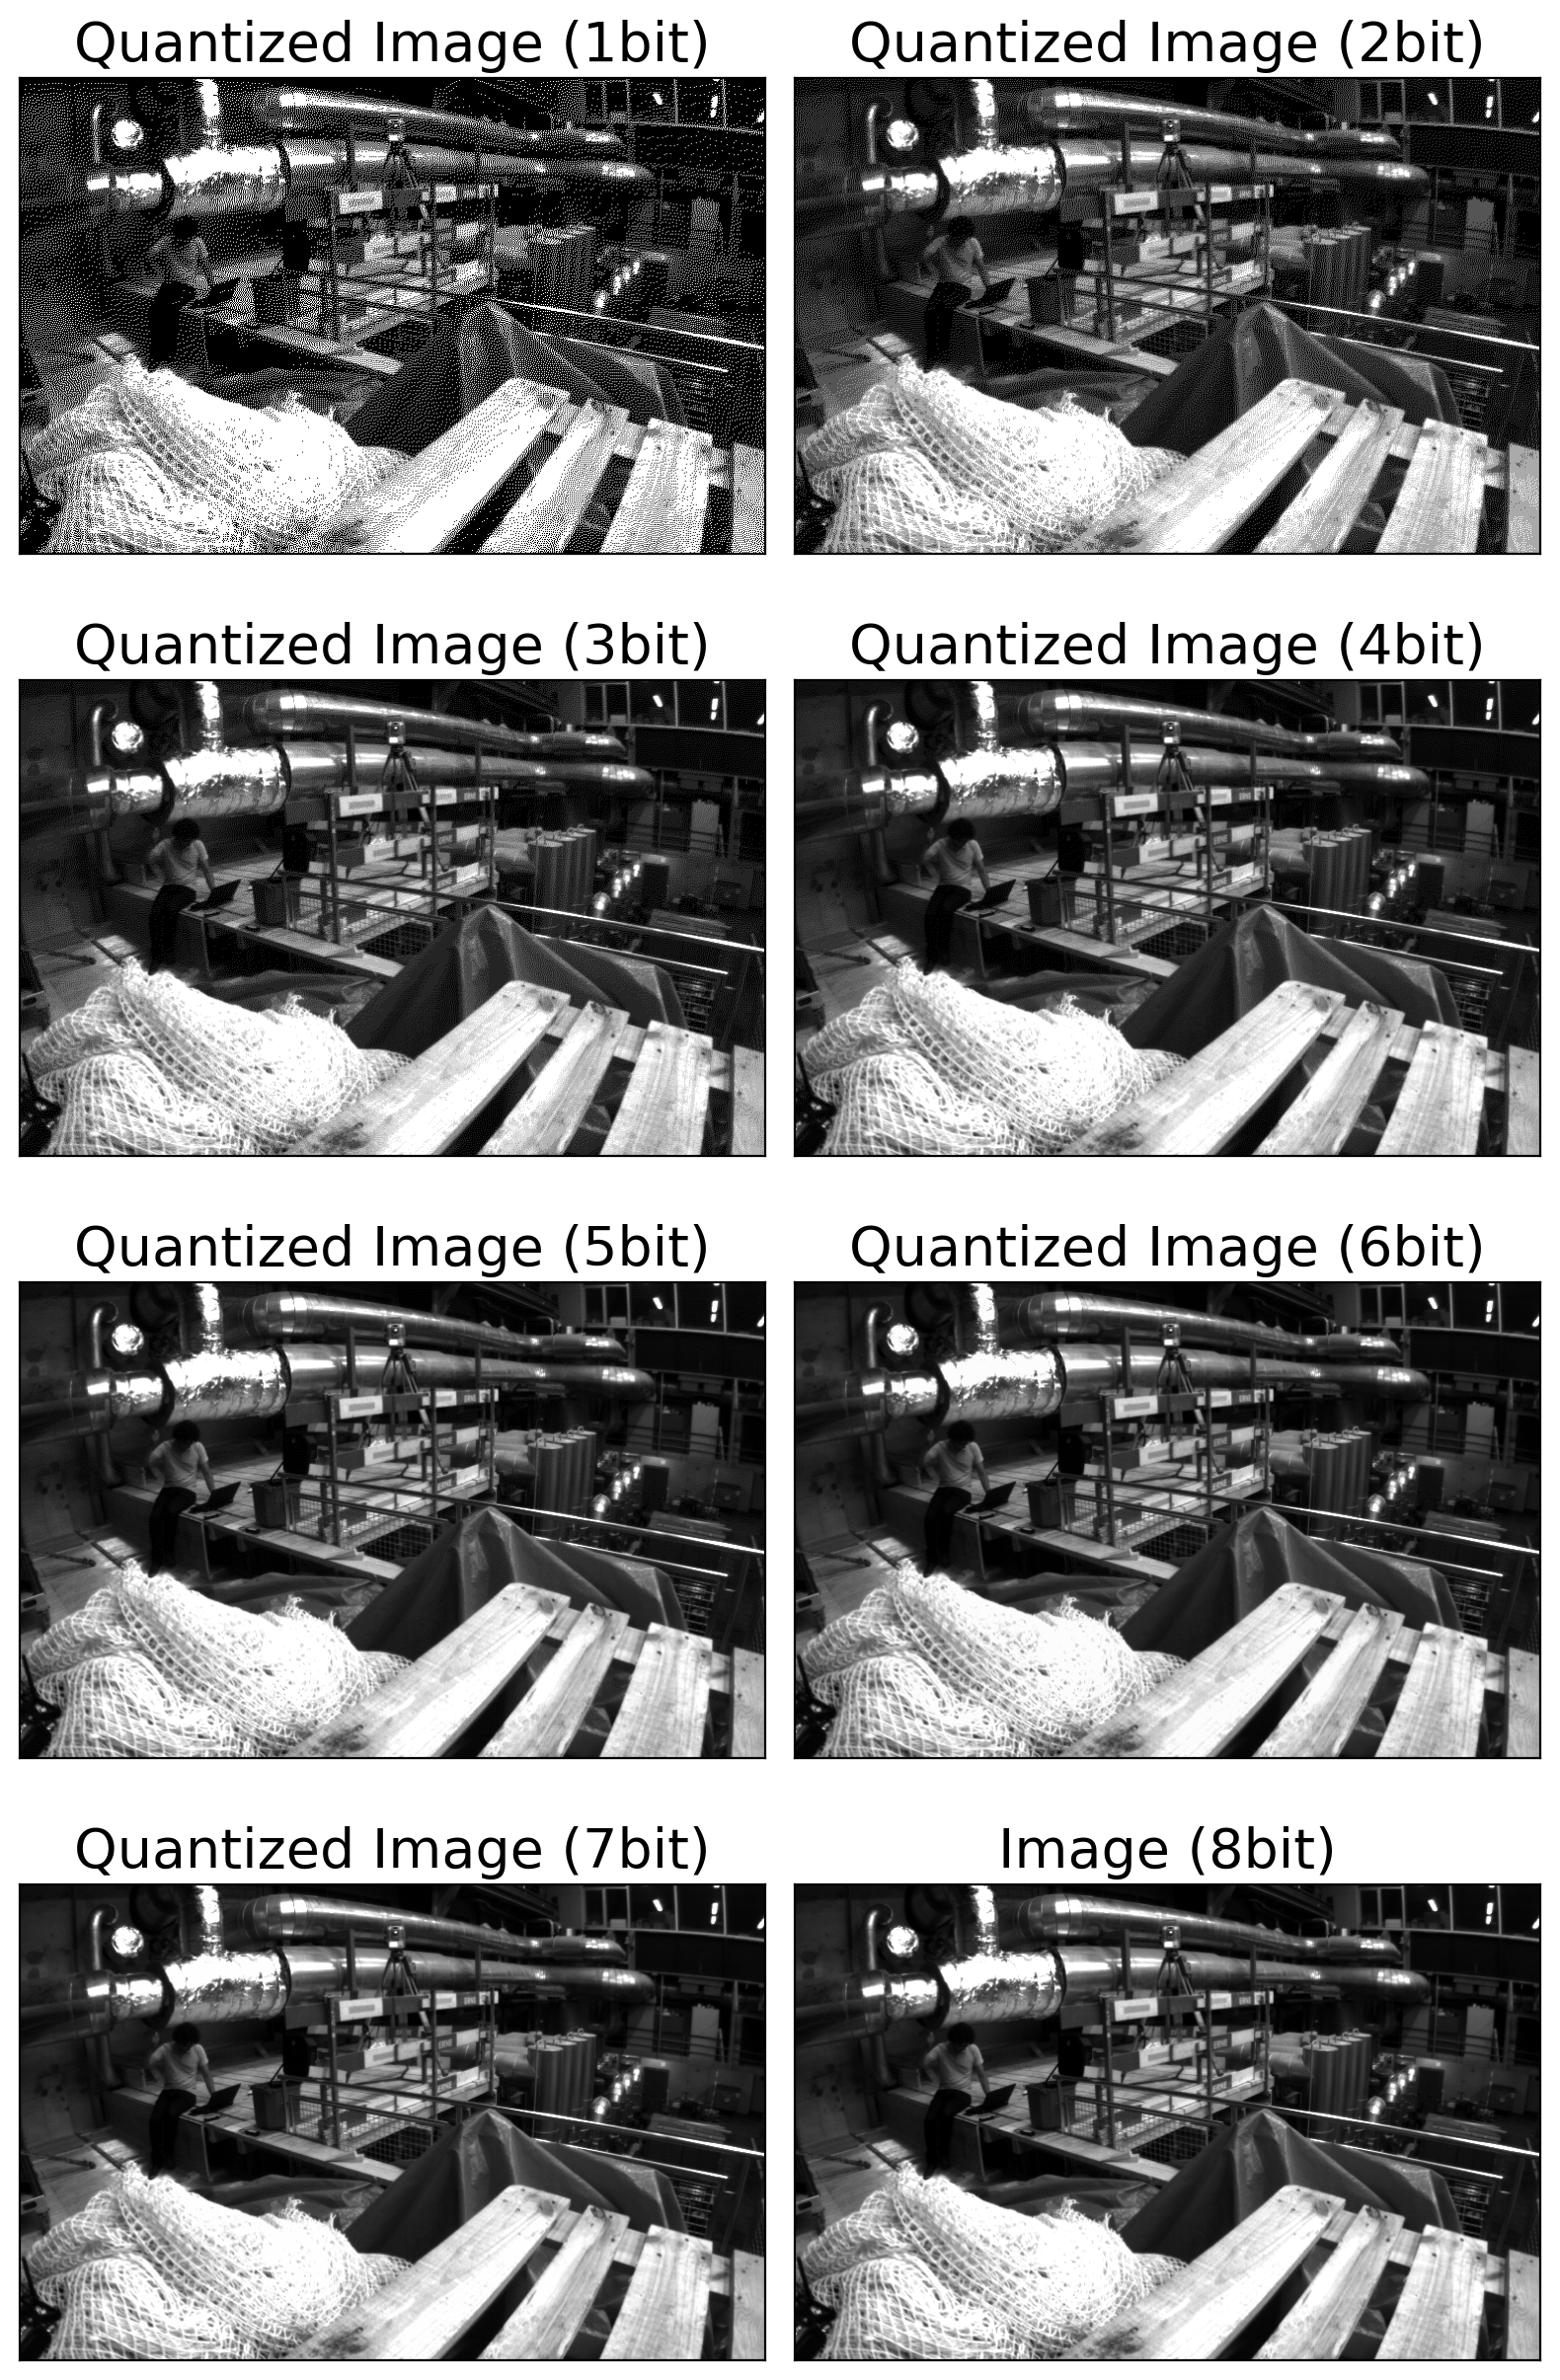

In [18]:
plt.figure(figsize=(8,12.5), dpi=200)

for i in range(1, 8):
    quantized_img = halftone_visual_model_Nbit(img_gray, i)
    
    plt.subplot(420 + i)
    plt.imshow(quantized_img, cmap="gray")
    plt.xticks([])
    plt.yticks([])
    plt.title(f"Quantized Image ({i}bit)", fontsize=20)

plt.subplot(428)
plt.imshow(img_gray, cmap="gray")
plt.title(f"Image (8bit)", fontsize=20)
plt.xticks([])
plt.yticks([])
    
plt.tight_layout()
plt.show()

Image_raw Size: (256, 256)
Image_fs  Size: (256, 256)
Image_jjn Size: (256, 256)


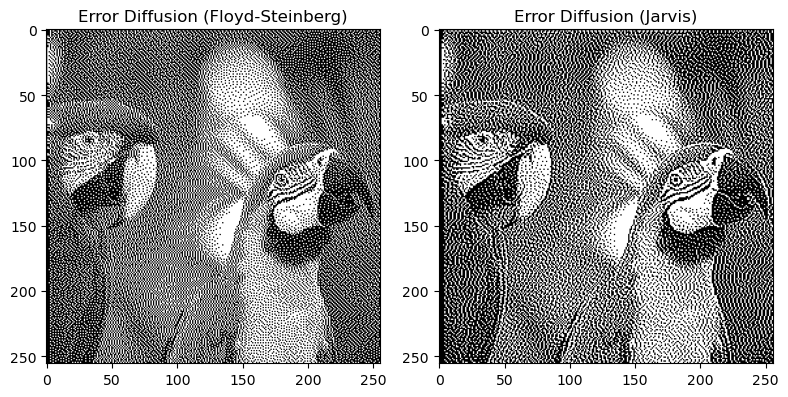

In [53]:
## Way.2 ErrorDiffusion (Floyd-Steinberg or Jarvis, Judice & Ninke)

img_halftone1 = halftone_error_diffusion_1bit(img_gray, "fs")
img_halftone2 = halftone_error_diffusion_1bit(img_gray, "jjn")

print(f"Image_raw Size: {img_gray.shape}")
print(f"Image_fs  Size: {img_halftone1.shape}")
print(f"Image_jjn Size: {img_halftone2.shape}")

plt.figure(figsize=(8,8), dpi=100)
plt.subplot(121)
plt.imshow(img_halftone1, cmap="gray")
plt.title("Error Diffusion (Floyd-Steinberg)")
plt.subplot(122)
plt.imshow(img_halftone2, cmap="gray")
plt.title("Error Diffusion (Jarvis)")

plt.tight_layout()
plt.show()

Image_raw Size: (256, 256)
Image_halftone Size: (256, 256)


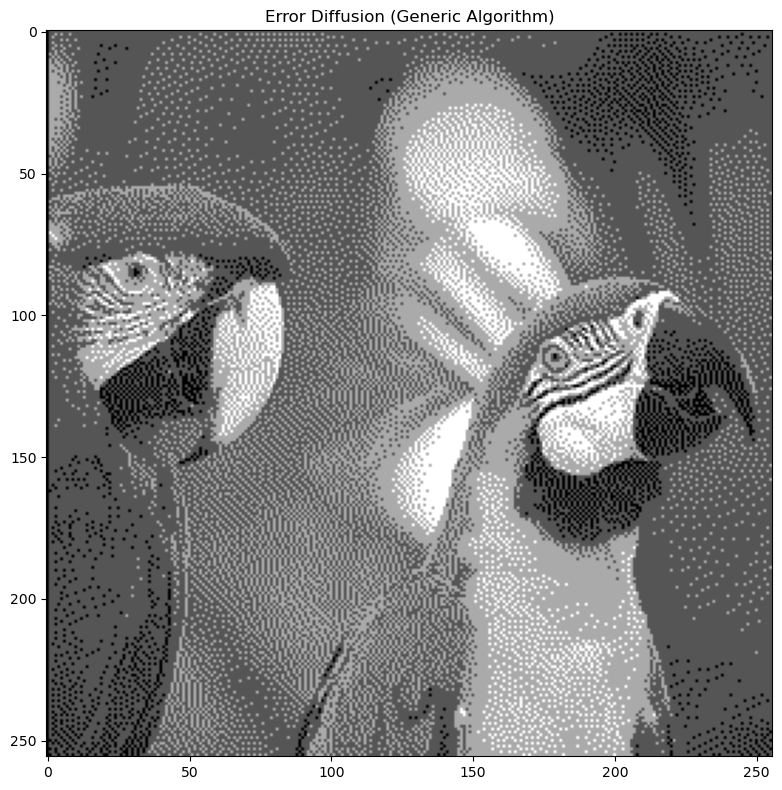

In [26]:
## Way.2 ErrorDiffusion (Custom)

# h = np.array([0, 0] + [.38, .10, .38, .14]).reshape(2, 3)
h = np.array([0, 0] + [7/16, 3/16, 5/16, 1/16]).reshape(2, 3)
img_halftone = error_diffusion_quantization(img_gray, h=h, N=2)

print(f"Image_raw Size: {img_gray.shape}")
print(f"Image_halftone Size: {img_halftone.shape}")

plt.figure(figsize=(8,8), dpi=100)
plt.imshow(img_halftone, cmap="gray")
plt.title("Error Diffusion (Generic Algorithm)")

plt.tight_layout()
plt.show()

## 3. 生成したハーフトーン画像の保存

In [3]:
import pathlib
from tqdm import tqdm
from glob import glob

from halftone_video import HalftoneVideo

In [4]:
# Create All simple-quantization images
bit_range = [5, 8]
# filter_names = ["jjn", "fs"]
filter_names = ["custom"]
quantization_method = "error_diffusion"     # "uniform" | "visual_model" | "error_diffusion"
# v_dirs = ["MH_01_easy", "MH_02_easy", "MH_03_median", "MH_04_difficult", "MH_05_difficult", "V1_01_easy", "V1_02_median", "V1_03_difficult", "V2_01_easy", "V2_02_median", "V2_03_difficult"]
v_dirs = ["MH_01_easy", "MH_03_median", "MH_05_difficult"]
v_dir_name = ["MH01", "MH03", "MH05"]

# w = np.array([0, 0] + [0.38, 0.1, 0.38, 0.14]).reshape(2, 3)   # [15 5 8 4]

res = [0.3333333333333333, 0.017543859649122806, 0.07017543859649122, 0.12280701754385964, 0.3157894736842105, 0.0, 0.017543859649122806, 0.07017543859649122, 0.017543859649122806, 0.03508771929824561, 0.0, 0.0]
w = np.array([0, 0, 0] + res).reshape(3, 5)
w = w / np.sum(w)
w = np.round(w, 4)

for i, v_dir in enumerate(v_dirs):
    for k in [0, 1]:
        RAW_DIR = f"/Users/tsy/slamFolder/datasets/euroc/{v_dir}/{v_dir_name[i]}_8bit/cam{k}/data"
#         GOAL_DIR = [f"/Users/tsy/slamFolder/datasets/euroc/{v_dir}/{quantization_method}/{i}bit/cam{k}/data" for i in range(bit_range[0], bit_range[1])]
        GOAL_DIR = [f"/Users/tsy/slamFolder/datasets/euroc/{v_dir}/{quantization_method}/{v_dir_name[i]}_{f}_1bit/cam{k}/data" for f in ["optim"]]
        
#         for i, goal_dir in enumerate(GOAL_DIR):
#             h_video = HalftoneVideo(RAW_IMAGE_DIR=RAW_DIR, HALFTONE_IMAGE_DIR=goal_dir)
#             h_video.create_halftone_video(option=quantization_method, bit=i+bit_range[0])
        
        for j, goal_dir in enumerate(GOAL_DIR):
            h_video = HalftoneVideo(RAW_IMAGE_DIR=RAW_DIR, HALFTONE_IMAGE_DIR=goal_dir)
            h_video.create_halftone_video(option=quantization_method, w=w, err_diff=filter_names[j])

100%|███████████████████████████████████████| 3682/3682 [01:07<00:00, 54.71it/s]


=== HALFTONE COMPLETE b ^_^ d ===
[SAVED DIRECTORY] /Users/tsy/slamFolder/datasets/euroc/MH_01_easy/error_diffusion/MH01_optim_1bit/cam0/data


100%|███████████████████████████████████████| 3682/3682 [01:09<00:00, 52.72it/s]


=== HALFTONE COMPLETE b ^_^ d ===
[SAVED DIRECTORY] /Users/tsy/slamFolder/datasets/euroc/MH_01_easy/error_diffusion/MH01_optim_1bit/cam1/data


100%|███████████████████████████████████████| 2700/2700 [00:46<00:00, 57.76it/s]


=== HALFTONE COMPLETE b ^_^ d ===
[SAVED DIRECTORY] /Users/tsy/slamFolder/datasets/euroc/MH_03_median/error_diffusion/MH03_optim_1bit/cam0/data


100%|███████████████████████████████████████| 2700/2700 [00:39<00:00, 67.64it/s]


=== HALFTONE COMPLETE b ^_^ d ===
[SAVED DIRECTORY] /Users/tsy/slamFolder/datasets/euroc/MH_03_median/error_diffusion/MH03_optim_1bit/cam1/data


100%|███████████████████████████████████████| 2273/2273 [00:43<00:00, 52.73it/s]


=== HALFTONE COMPLETE b ^_^ d ===
[SAVED DIRECTORY] /Users/tsy/slamFolder/datasets/euroc/MH_05_difficult/error_diffusion/MH05_optim_1bit/cam0/data


100%|███████████████████████████████████████| 2273/2273 [00:42<00:00, 53.30it/s]

=== HALFTONE COMPLETE b ^_^ d ===
[SAVED DIRECTORY] /Users/tsy/slamFolder/datasets/euroc/MH_05_difficult/error_diffusion/MH05_optim_1bit/cam1/data


In [16]:
# Create All blockwise quantization images
Ns = [4, 8, 16]
quantization_method = "block_wise"     #  "block_wise"
v_dirs = ["MH_01_easy", "MH_02_easy", "MH_03_median", "MH_04_difficult", "MH_05_difficult"]
h = np.array([0, 0] + [17, 5, 15, 3]).reshape(2, 3)
h = h / np.sum(h)

for v_dir in v_dirs:
    for k in [0, 1]:
        RAW_DIR = f"/Users/tsy/slamFolder/datasets/euroc/{v_dir}/8bit/cam{k}/data"
        GOAL_DIR = [f"/Users/tsy/slamFolder/datasets/euroc/{v_dir}/{quantization_method}/N{i}/cam{k}/data" for i in Ns]
        
        for i, goal_dir in enumerate(GOAL_DIR):
            h_video = HalftoneVideo(RAW_IMAGE_DIR=RAW_DIR, HALFTONE_IMAGE_DIR=goal_dir)
            h_video.create_halftone_video(option=quantization_method, bit=Ns[i])

100%|██████████████████████████████████████| 3682/3682 [00:25<00:00, 142.88it/s]


=== HALFTONE COMPLETE b ^_^ d ===
[SAVED DIRECTORY] /Users/tsy/slamFolder/datasets/euroc/MH_01_easy/block_wise/N4/cam0/data


100%|██████████████████████████████████████| 3682/3682 [00:22<00:00, 164.04it/s]


=== HALFTONE COMPLETE b ^_^ d ===
[SAVED DIRECTORY] /Users/tsy/slamFolder/datasets/euroc/MH_01_easy/block_wise/N8/cam0/data


100%|██████████████████████████████████████| 3682/3682 [00:22<00:00, 162.57it/s]


=== HALFTONE COMPLETE b ^_^ d ===
[SAVED DIRECTORY] /Users/tsy/slamFolder/datasets/euroc/MH_01_easy/block_wise/N16/cam0/data


100%|███████████████████████████████████████| 3682/3682 [00:37<00:00, 98.28it/s]


=== HALFTONE COMPLETE b ^_^ d ===
[SAVED DIRECTORY] /Users/tsy/slamFolder/datasets/euroc/MH_01_easy/block_wise/N4/cam1/data


100%|███████████████████████████████████████| 3682/3682 [00:38<00:00, 94.96it/s]


=== HALFTONE COMPLETE b ^_^ d ===
[SAVED DIRECTORY] /Users/tsy/slamFolder/datasets/euroc/MH_01_easy/block_wise/N8/cam1/data


100%|███████████████████████████████████████| 3682/3682 [00:41<00:00, 89.52it/s]


=== HALFTONE COMPLETE b ^_^ d ===
[SAVED DIRECTORY] /Users/tsy/slamFolder/datasets/euroc/MH_01_easy/block_wise/N16/cam1/data


100%|███████████████████████████████████████| 3040/3040 [00:43<00:00, 70.49it/s]


=== HALFTONE COMPLETE b ^_^ d ===
[SAVED DIRECTORY] /Users/tsy/slamFolder/datasets/euroc/MH_02_easy/block_wise/N4/cam0/data


100%|███████████████████████████████████████| 3040/3040 [00:38<00:00, 78.83it/s]


=== HALFTONE COMPLETE b ^_^ d ===
[SAVED DIRECTORY] /Users/tsy/slamFolder/datasets/euroc/MH_02_easy/block_wise/N8/cam0/data


100%|███████████████████████████████████████| 3040/3040 [00:33<00:00, 90.32it/s]


=== HALFTONE COMPLETE b ^_^ d ===
[SAVED DIRECTORY] /Users/tsy/slamFolder/datasets/euroc/MH_02_easy/block_wise/N16/cam0/data


100%|███████████████████████████████████████| 3040/3040 [00:32<00:00, 93.67it/s]


=== HALFTONE COMPLETE b ^_^ d ===
[SAVED DIRECTORY] /Users/tsy/slamFolder/datasets/euroc/MH_02_easy/block_wise/N4/cam1/data


100%|██████████████████████████████████████| 3040/3040 [00:25<00:00, 119.55it/s]


=== HALFTONE COMPLETE b ^_^ d ===
[SAVED DIRECTORY] /Users/tsy/slamFolder/datasets/euroc/MH_02_easy/block_wise/N8/cam1/data


100%|██████████████████████████████████████| 3040/3040 [00:21<00:00, 144.46it/s]


=== HALFTONE COMPLETE b ^_^ d ===
[SAVED DIRECTORY] /Users/tsy/slamFolder/datasets/euroc/MH_02_easy/block_wise/N16/cam1/data


100%|███████████████████████████████████████| 2700/2700 [00:28<00:00, 94.58it/s]


=== HALFTONE COMPLETE b ^_^ d ===
[SAVED DIRECTORY] /Users/tsy/slamFolder/datasets/euroc/MH_03_median/block_wise/N4/cam0/data


100%|██████████████████████████████████████| 2700/2700 [00:25<00:00, 105.73it/s]


=== HALFTONE COMPLETE b ^_^ d ===
[SAVED DIRECTORY] /Users/tsy/slamFolder/datasets/euroc/MH_03_median/block_wise/N8/cam0/data


100%|██████████████████████████████████████| 2700/2700 [00:20<00:00, 128.60it/s]


=== HALFTONE COMPLETE b ^_^ d ===
[SAVED DIRECTORY] /Users/tsy/slamFolder/datasets/euroc/MH_03_median/block_wise/N16/cam0/data


100%|███████████████████████████████████████| 2700/2700 [00:27<00:00, 97.29it/s]


=== HALFTONE COMPLETE b ^_^ d ===
[SAVED DIRECTORY] /Users/tsy/slamFolder/datasets/euroc/MH_03_median/block_wise/N4/cam1/data


100%|██████████████████████████████████████| 2700/2700 [00:24<00:00, 109.39it/s]


=== HALFTONE COMPLETE b ^_^ d ===
[SAVED DIRECTORY] /Users/tsy/slamFolder/datasets/euroc/MH_03_median/block_wise/N8/cam1/data


100%|██████████████████████████████████████| 2700/2700 [00:22<00:00, 119.02it/s]


=== HALFTONE COMPLETE b ^_^ d ===
[SAVED DIRECTORY] /Users/tsy/slamFolder/datasets/euroc/MH_03_median/block_wise/N16/cam1/data


100%|███████████████████████████████████████| 2033/2033 [00:22<00:00, 91.82it/s]


=== HALFTONE COMPLETE b ^_^ d ===
[SAVED DIRECTORY] /Users/tsy/slamFolder/datasets/euroc/MH_04_difficult/block_wise/N4/cam0/data


100%|██████████████████████████████████████| 2033/2033 [00:16<00:00, 123.75it/s]


=== HALFTONE COMPLETE b ^_^ d ===
[SAVED DIRECTORY] /Users/tsy/slamFolder/datasets/euroc/MH_04_difficult/block_wise/N8/cam0/data


100%|██████████████████████████████████████| 2033/2033 [00:14<00:00, 142.98it/s]


=== HALFTONE COMPLETE b ^_^ d ===
[SAVED DIRECTORY] /Users/tsy/slamFolder/datasets/euroc/MH_04_difficult/block_wise/N16/cam0/data


100%|██████████████████████████████████████| 2033/2033 [00:17<00:00, 113.44it/s]


=== HALFTONE COMPLETE b ^_^ d ===
[SAVED DIRECTORY] /Users/tsy/slamFolder/datasets/euroc/MH_04_difficult/block_wise/N4/cam1/data


100%|██████████████████████████████████████| 2033/2033 [00:15<00:00, 132.17it/s]


=== HALFTONE COMPLETE b ^_^ d ===
[SAVED DIRECTORY] /Users/tsy/slamFolder/datasets/euroc/MH_04_difficult/block_wise/N8/cam1/data


100%|██████████████████████████████████████| 2033/2033 [00:14<00:00, 144.93it/s]


=== HALFTONE COMPLETE b ^_^ d ===
[SAVED DIRECTORY] /Users/tsy/slamFolder/datasets/euroc/MH_04_difficult/block_wise/N16/cam1/data


100%|██████████████████████████████████████| 2273/2273 [00:22<00:00, 101.05it/s]


=== HALFTONE COMPLETE b ^_^ d ===
[SAVED DIRECTORY] /Users/tsy/slamFolder/datasets/euroc/MH_05_difficult/block_wise/N4/cam0/data


100%|██████████████████████████████████████| 2273/2273 [00:22<00:00, 100.37it/s]


=== HALFTONE COMPLETE b ^_^ d ===
[SAVED DIRECTORY] /Users/tsy/slamFolder/datasets/euroc/MH_05_difficult/block_wise/N8/cam0/data


100%|██████████████████████████████████████| 2273/2273 [00:18<00:00, 120.47it/s]


=== HALFTONE COMPLETE b ^_^ d ===
[SAVED DIRECTORY] /Users/tsy/slamFolder/datasets/euroc/MH_05_difficult/block_wise/N16/cam0/data


100%|███████████████████████████████████████| 2273/2273 [00:23<00:00, 97.47it/s]


=== HALFTONE COMPLETE b ^_^ d ===
[SAVED DIRECTORY] /Users/tsy/slamFolder/datasets/euroc/MH_05_difficult/block_wise/N4/cam1/data


100%|██████████████████████████████████████| 2273/2273 [00:21<00:00, 107.04it/s]


=== HALFTONE COMPLETE b ^_^ d ===
[SAVED DIRECTORY] /Users/tsy/slamFolder/datasets/euroc/MH_05_difficult/block_wise/N8/cam1/data


100%|██████████████████████████████████████| 2273/2273 [00:19<00:00, 119.59it/s]

=== HALFTONE COMPLETE b ^_^ d ===
[SAVED DIRECTORY] /Users/tsy/slamFolder/datasets/euroc/MH_05_difficult/block_wise/N16/cam1/data


## 4. その他のテスト

In [ ]:
# [Version.1]
# def halftone_visual_model_py(img, N):
#     # parameters
#     A0 = np.array([[0.21]])
#     A1 = np.array([[0.32]])
#     A2 = np.array([[0.31]])
#     A3 = np.array([[0.13]])
#     B  = np.array([[0.04]])
#     C  = np.array([[1]])
    
#     level = pow(2, N)
#     d = 255 / (level-1)

#     # processing
#     AQ0 = A0
#     AQ1 = A1
#     AQ2 = A2
#     AQ3 = A3
#     BQ  = B
#     CQ0 = -np.linalg.inv(C@B) @ C @ AQ0
#     CQ1 = -np.linalg.inv(C@B) @ C @ AQ1
#     CQ2 = -np.linalg.inv(C@B) @ C @ AQ2
#     CQ3 = -np.linalg.inv(C@B) @ C @ AQ3

#     xi = np.zeros((img.shape[1]+2, img.shape[0]+1))
#     vd = np.zeros((img.shape[1], img.shape[0]))
#     ud = img.T

#     for j in range(img.shape[0]):
#         for i in range(img.shape[1]):
#             vd[i,j] = np.round((CQ0 * xi[i,j] + CQ1 * xi[i,j+1] + CQ2 * xi[i+1,j] + CQ3 * xi[i+2,j] + ud[i,j]) / d) * d
#             xi[i+1, j+1] = AQ0 * xi[i,j] + AQ1 * xi[i,j+1] + AQ2 * xi[i+1,j] + AQ3 * xi[i+2,j] + BQ * (vd[i,j] - ud[i,j])

#     vd = vd.T
    
#     return vd

In [20]:
# img = cv2.imread("imgs/test.jpg")
# imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
imgHalftone = halftone.halftone_visual_model_cy(imgGray, 1)

# cv2.imwrite("imgs/img_copy.jpg", img)
# cv2.imwrite("imgs/img_gray.jpg", imgGray)
cv2.imwrite("imgs/img_halftone_v.jpg", imgHalftone)

True

In [3]:
%%time

N = 100000
x = 213

for _ in range(N):
    np.round(x/255)*255

CPU times: user 203 ms, sys: 2.39 ms, total: 205 ms
Wall time: 204 ms


In [31]:
%%time

N = 100000
x = 213

for _ in range(N):
    if x < 127:
        x = 255
    else:
        x = 0

CPU times: user 16.2 ms, sys: 608 µs, total: 16.8 ms
Wall time: 16.4 ms


In [59]:
img = cv2.imread("../datasets/samples/imgs/freiburg.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# img = np.clip(img, 0., 255.)

In [7]:
res = [0.3333333333333333, 0.017543859649122806, 0.07017543859649122, 0.12280701754385964, 0.3157894736842105, 0.0, 0.017543859649122806, 0.07017543859649122, 0.017543859649122806, 0.03508771929824561, 0.0, 0.0]
w = np.array([0, 0, 0] + res).reshape(3, 5)
w = w / np.sum(w)
w = np.round(w, 4)

np.round(res, 4)

array([0.3333, 0.0175, 0.0702, 0.1228, 0.3158, 0.    , 0.0175, 0.0702,
       0.0175, 0.0351, 0.    , 0.    ])